# Sorted AML Fractions - LSC Activity

In [1]:
import sys 
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)

In [2]:
def load_fractions(dem_path):
    # load CIBERSORT output
    dat = sc.read_csv(dem_path, first_column_names=True)
    dat = dat[:,~dat.var_names.isin(['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)'])]
    dat.obs.index.rename('Sample', inplace=True)

    # Absolute Scores
    absolute_scores = dat.to_df()
    absolute_scores.columns = absolute_scores.columns+'-Absolute'
    dat.obs = dat.obs.merge(absolute_scores, how = 'left', left_index=True, right_index=True)
    
    # Relative Scores (tumor only)
    relative_scores = dat.to_df()
    relative_scores = relative_scores.iloc[:,~relative_scores.columns.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    relative_scores = (relative_scores.transpose() / relative_scores.sum(axis=1).transpose()).transpose()
    relative_scores.columns = relative_scores.columns+'-Relative'
    dat.obs = dat.obs.merge(relative_scores, how = 'left', left_index=True, right_index=True)
    
    return dat

In [3]:
# Process Fractions
def process_fractions(adata, res=0.5):
    celltypes = ['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']
    
    adata = adata[:,~adata.var_names.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    adata.X = (adata.X.transpose() / adata.X.sum(axis=1)).transpose()

    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution = res)
    sc.tl.umap(adata)
    
    sc.pl.pca(adata, color=['leiden']+celltypes, color_map = 'RdBu_r', wspace = 0.3, ncols=4)
    
    return(adata)


In [4]:
from seaborn.categorical import _ViolinPlotter
from statannot import add_stat_annotation

class MyVPlot(_ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q25, q50, q75 = np.percentile(data, [25, 50, 75])
        self.draw_to_density(ax, center, q50, support, density, split,
                             linewidth=self.linewidth, )

def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, saturation=.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, saturation)
    if ax is None:
        ax = plt.gca()
    plotter.plot(ax)
    return ax

def violin_category(data, category, score, xlab = None, ylab = None, order=["Low", "High"], boxpairlist=[("Low", "High")], textformat = "star", swarm=True, swarmsize=5):
    data = data.obs
    p1 = my_violinplot(data = data, x = category, y = score, scale='width', order=order, inner="quartile")
    if swarm==True:
        p1 = sns.swarmplot(data = data, x = category, y = score, order=order, color="black", size = swarmsize)
    add_stat_annotation(p1, data=data, x= category, y= score, order=order, box_pairs=boxpairlist,
                        test='Mann-Whitney', text_format= textformat, loc='outside', verbose=0)
    if xlab != None:
        plt.xlabel(xlab)
    if ylab != None:
        plt.ylabel(ylab)
    sns.despine()

In [5]:
%%R -w 8 -h 4 --units in -r 200
require("survival")
library(tidyverse)
library(ggpubr)
library(survminer)

R[write to console]: Loading required package: survival

R[write to console]: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Functionally Validated LSC Fractions

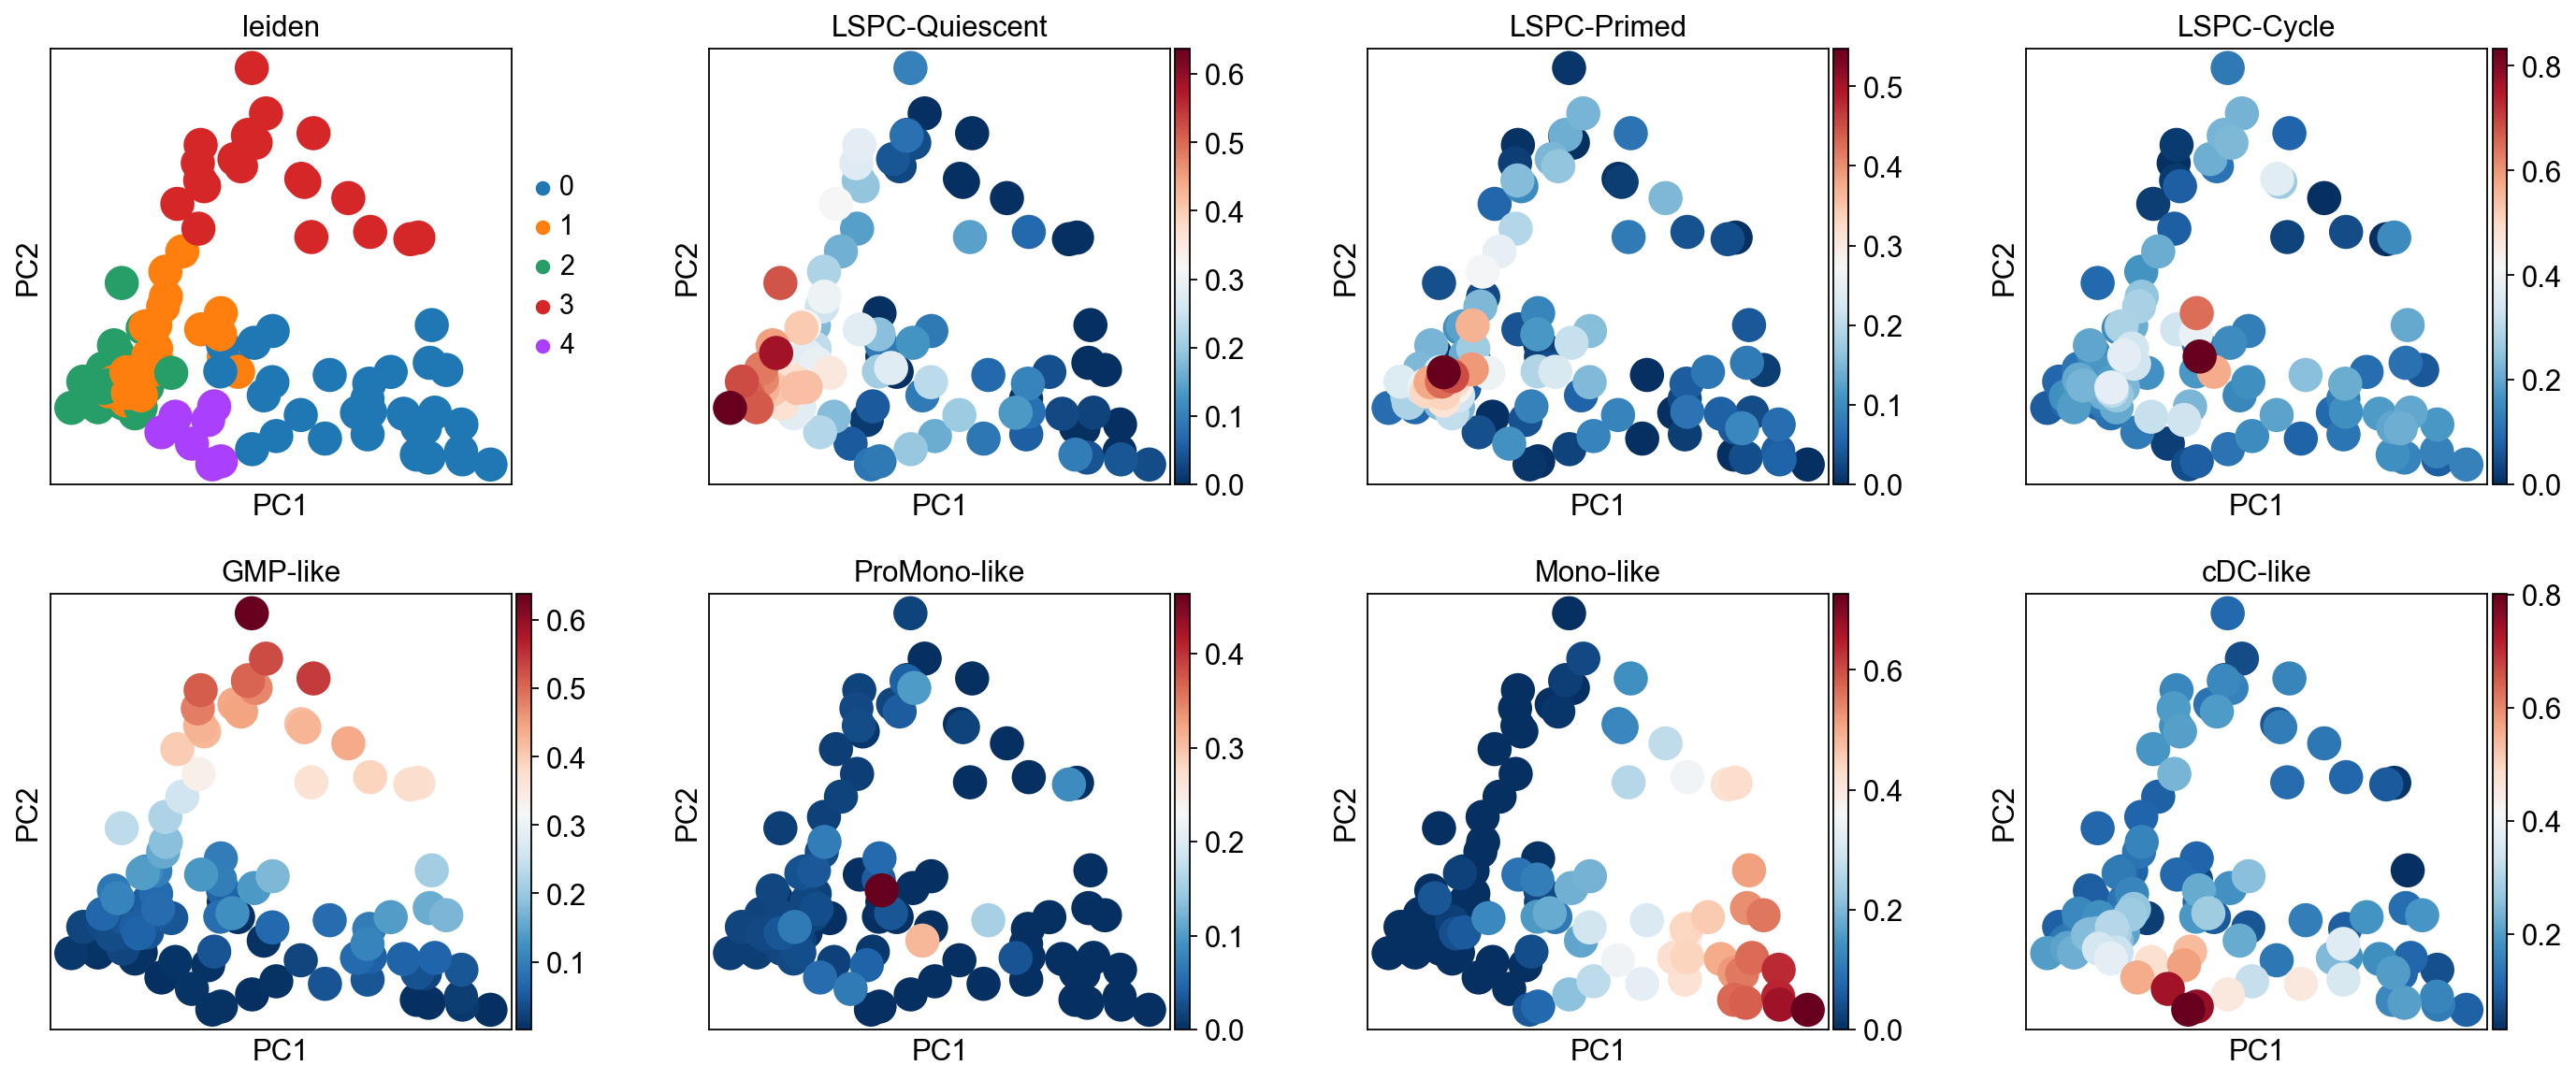

,B-Absolute,CTL-Absolute,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,Monocyte-Absolute,NK-Absolute,Plasma-Absolute,...,leiden,Sample,Patient,fraction,samp_frac,LSC status,uniqueID,LSC_Frequency,frequency_cat,new_frequency_cat
LSC0001_CD34mCD38m,0.424229,0.019086,0.238961,18.795918,0.401809,0.206428,0.474813,1.447356,0.233423,0.069807,...,1,LSC0001,90295,CD34mCD38m,LSC0001_CD34mCD38m,-,A5_b2,NE,NE,NE
LSC0001_CD34pCD38m,0.137161,0.892244,5.945861,1.027860,1.377448,2.679355,0.000000,0.398436,0.019347,0.148736,...,3,LSC0001,90295,CD34pCD38m,LSC0001_CD34pCD38m,+,A2_b2,7213,med,med-high
LSC0001_CD34pCD38p,0.079102,0.528855,8.309251,1.530146,0.104221,1.354740,0.000000,0.399566,0.020331,0.118868,...,3,LSC0001,90295,CD34pCD38p,LSC0001_CD34pCD38p,-,A3.3_b2,NE,NE,NE
LSC0002_CD34mCD38p,1.090392,0.949458,1.163102,4.258364,1.577820,0.000000,15.519322,1.874642,0.352317,0.636757,...,0,LSC0002,90716,CD34mCD38p,LSC0002_CD34mCD38p,-,B4_b2,NE,NE,NE
LSC0002_CD34pCD38m,0.204275,0.751188,7.265747,0.233498,0.043451,4.017636,0.000000,0.821984,0.013215,0.325132,...,3,LSC0002,90716,CD34pCD38m,LSC0002_CD34pCD38m,+,B2_b2,"43,681",med,med-high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSC0074_CD34pCD38p,0.209141,0.482849,6.263955,2.869937,1.804481,0.554446,0.278477,1.066228,0.011712,0.165253,...,3,LSC0074,110500,CD34pCD38p,LSC0074_CD34pCD38p,+,I10_b4,"less than 10,000 (probably much less)",NaN,NaN
LSC0076_CD34mCD38m,2.172230,1.129160,0.053284,0.598986,0.106550,1.111063,0.708282,6.191735,0.000000,0.133446,...,4,LSC0076,90686,CD34mCD38m,LSC0076_CD34mCD38m,-,G13_b4,NE,NE,NE
LSC0076_CD34mCD38p,0.652221,0.989573,2.001715,2.273849,0.448300,0.000000,7.026440,1.295971,0.482887,0.385136,...,0,LSC0076,90686,CD34mCD38p,LSC0076_CD34mCD38p,-,F13_b4,NE,NE,NE
LSC0077_CD34pCD38m,0.107347,0.715121,0.007726,1.773734,6.111110,2.185036,0.000000,0.385111,0.000000,0.064289,...,1,LSC0077,110484,CD34pCD38m,LSC0077_CD34pCD38m,+,C12_b4,4170,high,high


In [6]:
lsc = load_fractions('../Figure_Scripts/Data/Fig1_SingleCell_LSC/CIBERSORTx_LSC_Fractions.csv')
lsc = process_fractions(lsc)
# Get Coldata
anno = pd.read_csv("../Figure_Scripts/Data/Fig1_SingleCell_LSC/LSC_frequencies.csv")
anno['ID'] = anno['Sample'] + "_" + anno['fraction']    
anno = anno.set_index('ID') 

# Replace LSC Fraction names 
lsc.obs_names = lsc.obs_names.str.replace('_Bl', '')
lsc.obs = lsc.obs.merge(anno, how='left', left_index=True, right_index=True)
lsc.obs

In [7]:
lsc.obs['fraction'] = lsc.obs['fraction'].str.replace('p','+').str.replace('m','-').str.replace('CD38', '\nCD38')

### Cell Type Abundance by Immunophenotypic Fraction

In [8]:
lsc_todf = lsc.obs[['fraction']].join(lsc.to_df())

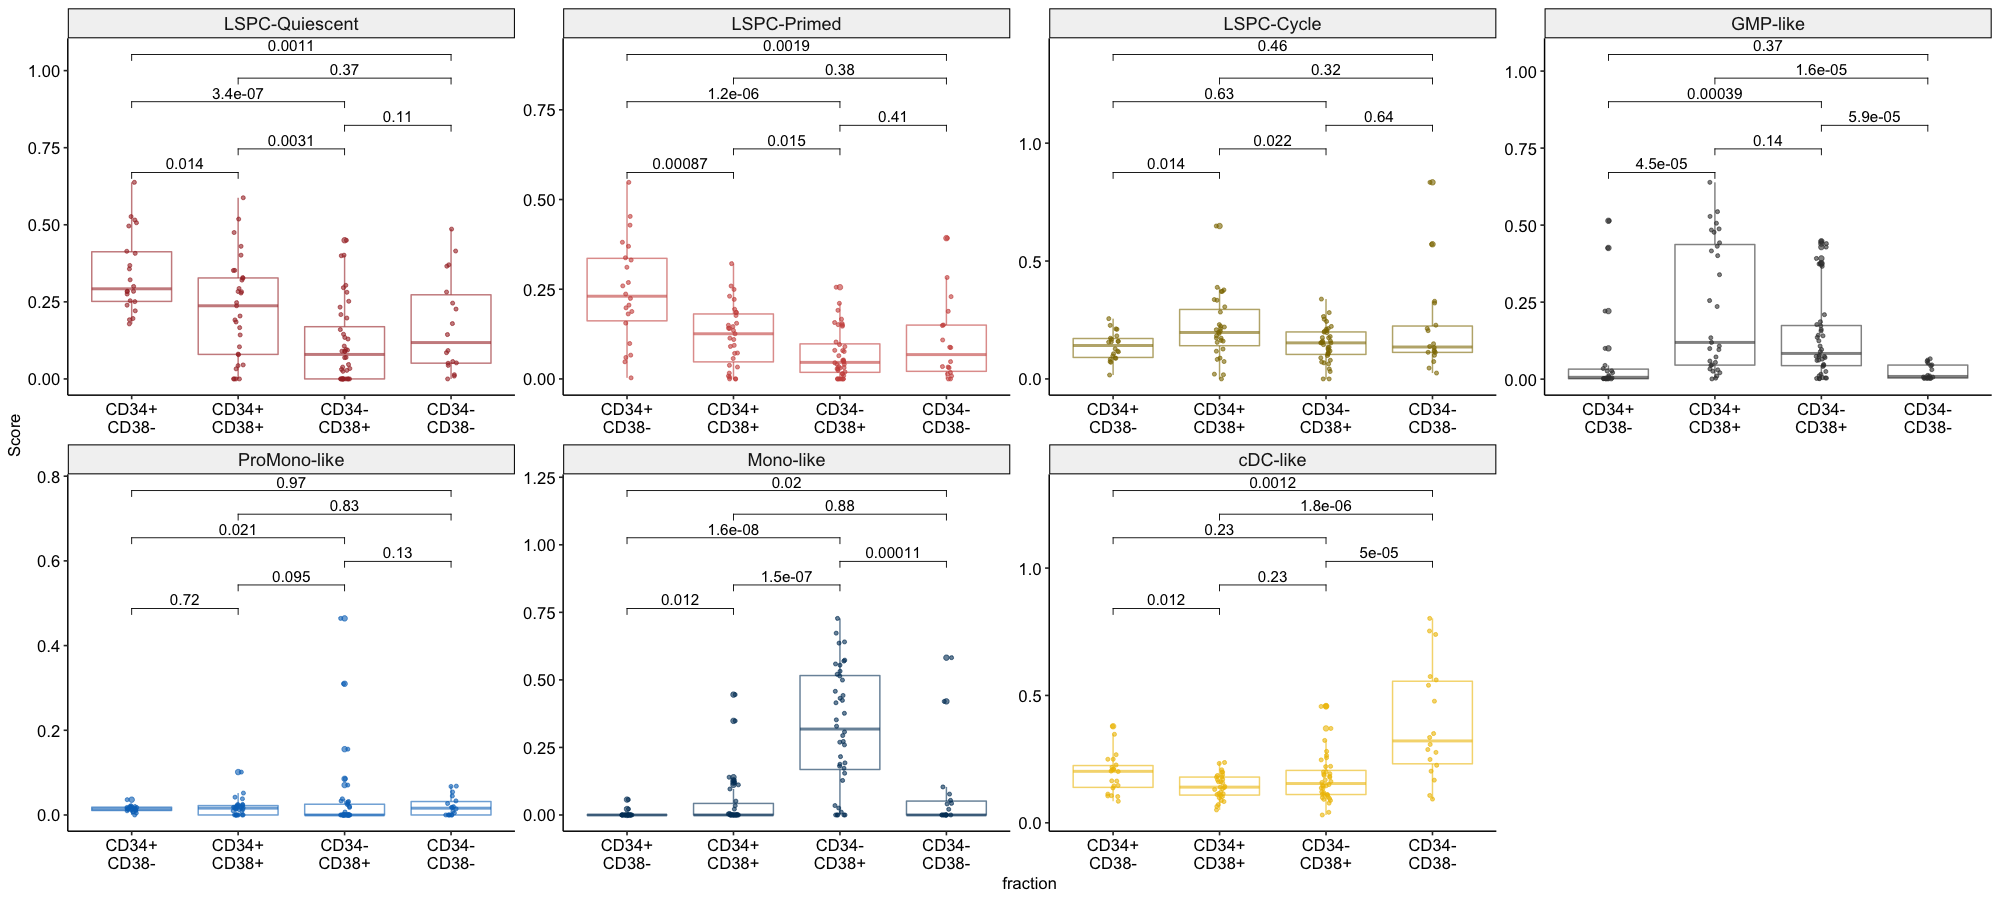

In [11]:
%%R -i lsc_todf -w 20 -h 9 --units in -r 100

#hierarchy_colors = c('#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')
hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')


lsc_todf <- lsc_todf %>% 
    gather(-`fraction`, key = "CellType", value = "Score") %>% 
    mutate(fraction = factor(fraction, levels = c('CD34+\nCD38-', 'CD34+\nCD38+', 'CD34-\nCD38+', 'CD34-\nCD38-'))) %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
    
lsc_todf %>% 
    ggplot(aes(x = `fraction`, y = Score, color = CellType)) + 
    geom_boxplot() + geom_jitter(width=0.05, size=1) + 
    facet_wrap(.~CellType, ncol=4, scales='free') + 
    theme_pubr() + 
    theme(strip.text.x = element_text(size=13)) +
    stat_compare_means(label = "p.format", comparisons = list(c('CD34+\nCD38-', 'CD34+\nCD38+'), c('CD34+\nCD38+', 'CD34-\nCD38+'), c('CD34-\nCD38+', 'CD34-\nCD38-'),
                                                              c('CD34+\nCD38-', 'CD34-\nCD38+'), c('CD34+\nCD38+', 'CD34-\nCD38-'), c('CD34+\nCD38-', 'CD34-\nCD38-')
                                                              ), method='wilcox.test') + 
    scale_color_manual(values = hierarchy_colors) +
    theme(legend.position='None') 

### Cell Type Abundance by Functional LSC Activity

In [14]:
lsc_todf = lsc.obs[['LSC status', 'fraction']].join(lsc.to_df())

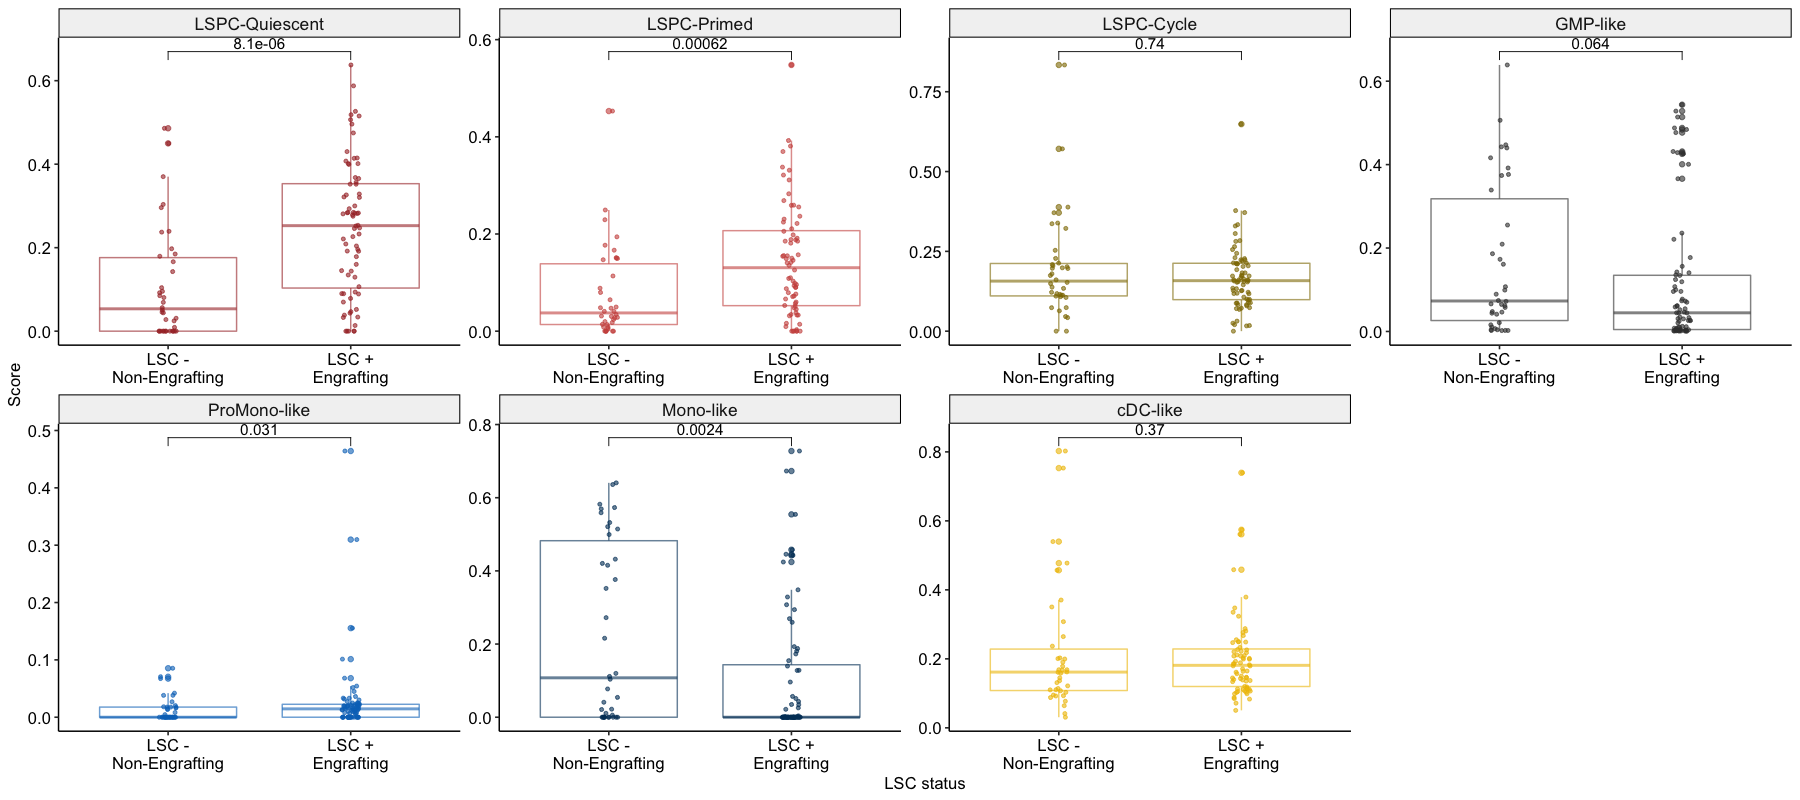

In [15]:
%%R -i lsc_todf -w 18 -h 8 --units in -r 100

#hierarchy_colors = c('#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')
hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')


lsc_todf <- lsc_todf %>% 
    gather(-c(`LSC status`, fraction), key = "CellType", value = "Score") %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
    
lsc_todf %>% 
    filter(`LSC status` != 'multilineage') %>% 
    mutate(`LSC status` = ifelse(`LSC status` == '+', 'LSC +\nEngrafting', 'LSC -\nNon-Engrafting')) %>%
    ggplot(aes(x = `LSC status`, y = Score, color = CellType)) + 
    geom_boxplot() + geom_jitter(width=0.05, size=1) + 
    facet_wrap(.~CellType, ncol=4, scales='free') + 
    theme_pubr() + 
    theme(strip.text.x = element_text(size=12.5)) +
    stat_compare_means(label = "p.format", comparisons = list(c('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')), method='wilcox.test') + 
    scale_color_manual(values = hierarchy_colors) +
    theme(legend.position='None') 

Across all sorted AML fractions, Quiescent and Primed LSPC are highly associated with functional LSC+ activity. 

In contrast, Mono-like abundance was negatively associated with LSC+ activity.

#### Functional LSC Activity - CD34+ Fractions only

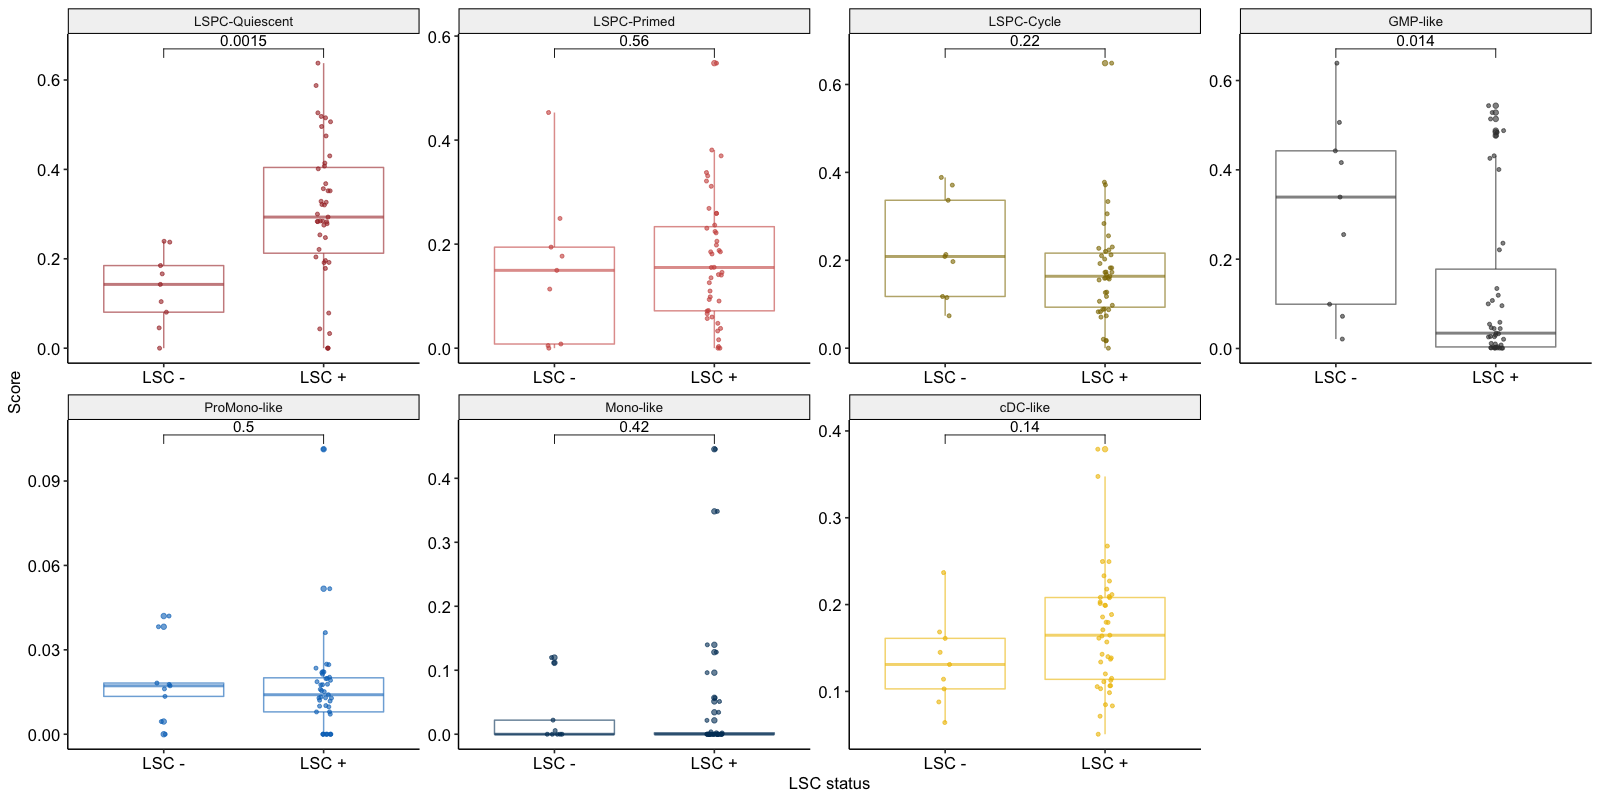

In [16]:
%%R -i lsc_todf -w 16 -h 8 --units in -r 100

#hierarchy_colors = c('#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')
hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')


lsc_todf <- lsc_todf %>% 
    filter(fraction %>% str_detect('CD34\\+')) %>% 
    gather(-`LSC status`, -fraction, key = "CellType", value = "Score") %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
    
lsc_todf %>% 
    filter(`LSC status` != 'multilineage') %>% 
    mutate(`LSC status` = ifelse(`LSC status` == '+', 'LSC +', 'LSC -')) %>%
    ggplot(aes(x = `LSC status`, y = Score, color = CellType)) + 
    geom_boxplot() + geom_jitter(width=0.05, size=1) + 
    facet_wrap(.~CellType, ncol=4, scales='free') + 
    theme_pubr() + 
    stat_compare_means(label = "p.format", comparisons = list(c('LSC -', 'LSC +')), method='wilcox.test') + 
    scale_color_manual(values = hierarchy_colors) +
    theme(legend.position='None') 

When filtering exclusively for CD34+ fractions, Quiescent LSPC are positively associated with LSC activity, and GMP-like cells are negatively associated with LSC activity

#### Functional LSC Activity - CD34- Fractions only

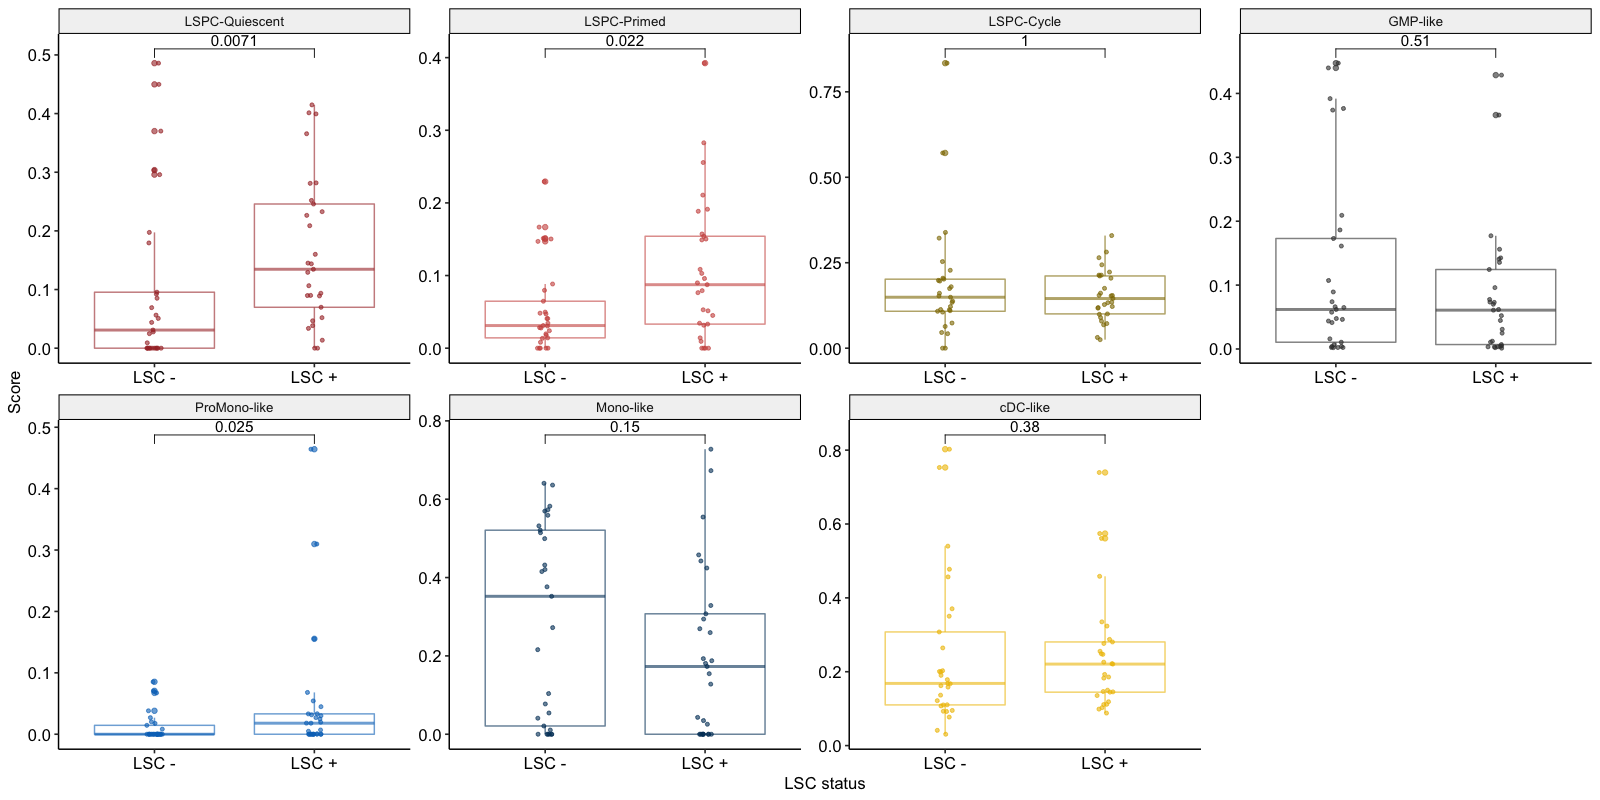

In [17]:
%%R -i lsc_todf -w 16 -h 8 --units in -r 100

#hierarchy_colors = c('#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')
hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')


lsc_todf <- lsc_todf %>% 
    filter(fraction %>% str_detect('CD34-')) %>% 
    gather(-`LSC status`, -fraction, key = "CellType", value = "Score") %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
    
lsc_todf %>% 
    filter(`LSC status` != 'multilineage') %>% 
    mutate(`LSC status` = ifelse(`LSC status` == '+', 'LSC +', 'LSC -')) %>%
    ggplot(aes(x = `LSC status`, y = Score, color = CellType)) + 
    geom_boxplot() + geom_jitter(width=0.05, size=1) + 
    facet_wrap(.~CellType, ncol=4, scales='free') + 
    theme_pubr() + 
    stat_compare_means(label = "p.format", comparisons = list(c('LSC -', 'LSC +')), method='wilcox.test') + 
    scale_color_manual(values = hierarchy_colors) +
    theme(legend.position='None') 

When filtering exclusively for CD34- fractions, Quiescent LSPC and Primed LSPC are both significantly associated with LSC activity 

Notably, ProMono-like abundance is also associated with LSC activity in these CD34- fractions

## Benchmarking against CD34/CD38 Immunophenotype

AML immunophenotype is known to be inconsistently associated with LSC activity. Can cell type abundance from AML deconvolution enable more accurate predictions? 

To evaluate this we will build LSC classifiers from either CD34 and CD38 immunophenotype or cell type abundance estimates. We will then measure classifier performance (AUC) through 5-fold cross validation and repeat this process 1000 times, shuffling the data in between each iteration. Each time we train a new classifier we will perform a gridsearch with inner 5-fold cross validation loop to identify the best hyperparameters. 

The result of this repeated nested cross-validation will be 1000 summary AUCs for each feature set, each derived from nested cross-validation on the data.

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [77]:
def train_rf(X, y, cv):
    rf = RandomForestClassifier()
    parameter_grid = { 
        'n_estimators': [10, 20, 50, 100],
        'max_depth': [1, 2, 3, 4]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=parameter_grid, cv=cv)
    grid_search.fit(X, y)
    rf = RandomForestClassifier(**grid_search.best_params_)
    rf.fit(X, y)
    return(rf)


def train_logreg_L2(X, y, cv): 
    lr = LogisticRegression(penalty='l2', solver = 'liblinear', multi_class='auto', max_iter=1000)
    parameter_grid = {
        'class_weight' : ['balanced', None],
        'C' : [0.01, 0.1, 1.0, 10.0]
    }
    grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=cv)
    grid_search.fit(X, y)
    lr = LogisticRegression(penalty='l2', **grid_search.best_params_)
    lr.fit(X, y)
    return(lr)

In [78]:
def nested_kfold_ROC(x, y, i, model = 'rf', k_inner=5, k_outer=5):
    
    # Set up cross validation CV
    cv = StratifiedKFold(n_splits=k_outer, shuffle=True, random_state=i)
    
    accs = []
    aucs = []
    
    inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=i)

    for train,test in cv.split(x,y):
        if model == 'lr':
            model = train_logreg_L2(x.iloc[train], y[train], inner_cv)
        elif model == 'rf':
            model = train_rf(x.iloc[train], y[train], inner_cv)
        
        prediction = model.predict(x.iloc[test])
        accs.append(accuracy_score(y[test], prediction))

        proba = model.predict_proba(x.iloc[test])
        aucs.append(roc_auc_score(y[test], proba[:, 1]))
        
    mean_auc = np.mean(aucs)
    mean_acc = np.mean(accs)

    return(mean_auc, mean_acc)

In [79]:
def repeated_nested_kfold(x, y, n_iterations, model, features, k_inner=5, k_outer=5):
    auc_scores = list()
    accuracy_scores = list()
    index = list()

    for i in range(n_iterations): 
        auc, acc = nested_kfold_ROC(x, y, i = i, model = model, k_inner=k_inner, k_outer=k_outer)
        auc_scores.append(auc)
        accuracy_scores.append(acc)
        index.append(i)


    ### Plot AUC Distribution ############################################################
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100; lower = max(0.0, np.percentile(auc_scores, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100; upper = min(1.0, np.percentile(auc_scores, p))
    print('\n\nMedian AUC = %.f%%. \n%.1f confidence interval: %.1f%% and %.1f%%.\n' % (np.median(auc_scores)*100, alpha*100, lower*100, upper*100))

    # plot scores
    plt.hist(auc_scores)
    plt.title('AUC')
    plt.axvline(np.median(auc_scores), color='red')
    plt.show()


    ### Plot Accuracy Distribution ############################################################
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100; lower = max(0.0, np.percentile(accuracy_scores, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100; upper = min(1.0, np.percentile(accuracy_scores, p))
    print('\n\nMedian Accuracy = %.f%%. \n%.1f confidence interval: %.1f%% and %.1f%%.\n' % (np.median(accuracy_scores)*100, alpha*100, lower*100, upper*100))

    # plot scores
    plt.hist(accuracy_scores)
    plt.title('Accuracy')
    plt.axvline(np.median(accuracy_scores), color='red')
    plt.show()

    return(pd.DataFrame(data={'AUC_'+model+'_'+features : auc_scores, 'accuracy_'+model+'_'+features : accuracy_scores}, index = index))

In [80]:
def compare_repeated_nested_kfold_cv(y, x, feature_name, n_iter = 1000, k_outer = 5, k_inner = 5, lr = True, rf = True):

    performance = pd.DataFrame(index=list(range(0,n_iter)))

    if lr == True:
        print("\n\n### LOGISTIC REGRESSION ###############################################################")
        model = 'lr'
        temp_scores = repeated_nested_kfold(x, y, n_iterations = n_iter, model = model, features = feature_name, k_inner=5, k_outer=5)
        performance = performance.join(temp_scores)

    if rf == True:
        print("\n\n### Random Forest ###############################################################")
        model = 'rf'
        temp_scores = repeated_nested_kfold(x, y, n_iterations = n_iter, model = model, features = feature_name, k_inner=5, k_outer=5)
        performance = performance.join(temp_scores)
        
    return(performance)

## Define Number of Iterations

In [81]:
n_iterations = 1000

In [82]:
### Prep LSC fraction data.

# Remove multi-lineage engrafting fractions
lsc_noML = lsc[lsc.obs['LSC status'] != 'multilineage']

# Re-format features to include cell type abundance and immunophenotypic fractions
x_frac4levels = lsc_noML.obs[['fraction']].join(lsc_noML.to_df())
x_frac4levels = x_frac4levels.rename(columns={'fraction':'Fraction'})
x_frac4levels['Fraction'] = np.where(x_frac4levels['Fraction'] == 'CD34-\nCD38-', 0,
                                np.where(x_frac4levels['Fraction'] == 'CD34-\nCD38+', 1,
                                        np.where(x_frac4levels['Fraction'] == 'CD34+\nCD38+', 2,
                                                np.where(x_frac4levels['Fraction'] == 'CD34+\nCD38-', 3, np.nan))))
x_frac4levels

,Fraction,GMP-like,LSPC-Cycle,LSPC-Primed,LSPC-Quiescent,Mono-like,ProMono-like,cDC-like
LSC0001_CD34mCD38m,0.0,0.010602,0.833882,0.017826,0.009158,0.021065,0.000000,0.107466
LSC0001_CD34pCD38m,3.0,0.425800,0.073608,0.098643,0.191876,0.000000,0.007131,0.202942
LSC0001_CD34pCD38p,2.0,0.638890,0.117651,0.008013,0.104165,0.000000,0.017213,0.114067
LSC0002_CD34mCD38p,1.0,0.047666,0.174515,0.064662,0.000000,0.636009,0.000000,0.077147
LSC0002_CD34pCD38m,3.0,0.513981,0.016518,0.003074,0.284209,0.000000,0.017519,0.164699
...,...,...,...,...,...,...,...,...
LSC0074_CD34pCD38p,2.0,0.487802,0.223495,0.140523,0.043177,0.021686,0.000000,0.083318
LSC0076_CD34mCD38m,0.0,0.004081,0.045880,0.008161,0.085102,0.054251,0.000000,0.802525
LSC0076_CD34mCD38p,1.0,0.107236,0.121815,0.024016,0.000000,0.376421,0.000000,0.370512
LSC0077_CD34pCD38m,3.0,0.000693,0.159034,0.547925,0.195911,0.000000,0.011775,0.084663


In [83]:
### Dependent Variable: Functional LSC Activity for 110 AML fractions
lsc_noML.obs['lsc_status'] = np.where(lsc_noML.obs['LSC status'] == '+', 1, 0)
y = lsc_noML.obs[['lsc_status']].values.flatten()
y

Trying to set attribute `.obs` of view, copying.


array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [84]:
### Feature Set 1: Cell Type Only
x_celltype = x_frac4levels[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']]
x_celltype

,LSPC-Quiescent,LSPC-Primed,LSPC-Cycle,GMP-like,ProMono-like,Mono-like,cDC-like
LSC0001_CD34mCD38m,0.009158,0.017826,0.833882,0.010602,0.000000,0.021065,0.107466
LSC0001_CD34pCD38m,0.191876,0.098643,0.073608,0.425800,0.007131,0.000000,0.202942
LSC0001_CD34pCD38p,0.104165,0.008013,0.117651,0.638890,0.017213,0.000000,0.114067
LSC0002_CD34mCD38p,0.000000,0.064662,0.174515,0.047666,0.000000,0.636009,0.077147
LSC0002_CD34pCD38m,0.284209,0.003074,0.016518,0.513981,0.017519,0.000000,0.164699
...,...,...,...,...,...,...,...
LSC0074_CD34pCD38p,0.043177,0.140523,0.223495,0.487802,0.000000,0.021686,0.083318
LSC0076_CD34mCD38m,0.085102,0.008161,0.045880,0.004081,0.000000,0.054251,0.802525
LSC0076_CD34mCD38p,0.000000,0.024016,0.121815,0.107236,0.000000,0.376421,0.370512
LSC0077_CD34pCD38m,0.195911,0.547925,0.159034,0.000693,0.011775,0.000000,0.084663


In [85]:
from sklearn.preprocessing import OneHotEncoder
OneHot = OneHotEncoder()

### Feature Set 2: Immunophenotype only
x_fraconly = pd.DataFrame(data = OneHot.fit_transform(x_frac4levels[['Fraction']]).toarray(), index = x_frac4levels.index, columns = ['34m38m', '34m38p', '34p38p', '34p38m'])
x_fraconly

,34m38m,34m38p,34p38p,34p38m
LSC0001_CD34mCD38m,1.0,0.0,0.0,0.0
LSC0001_CD34pCD38m,0.0,0.0,0.0,1.0
LSC0001_CD34pCD38p,0.0,0.0,1.0,0.0
LSC0002_CD34mCD38p,0.0,1.0,0.0,0.0
LSC0002_CD34pCD38m,0.0,0.0,0.0,1.0
...,...,...,...,...
LSC0074_CD34pCD38p,0.0,0.0,1.0,0.0
LSC0076_CD34mCD38m,1.0,0.0,0.0,0.0
LSC0076_CD34mCD38p,0.0,1.0,0.0,0.0
LSC0077_CD34pCD38m,0.0,0.0,0.0,1.0


## LSC Prediction

#### Classification with Full Hierarchy



### LOGISTIC REGRESSION ###############################################################


Median AUC = 78%. 
95.0 confidence interval: 74.3% and 80.2%.



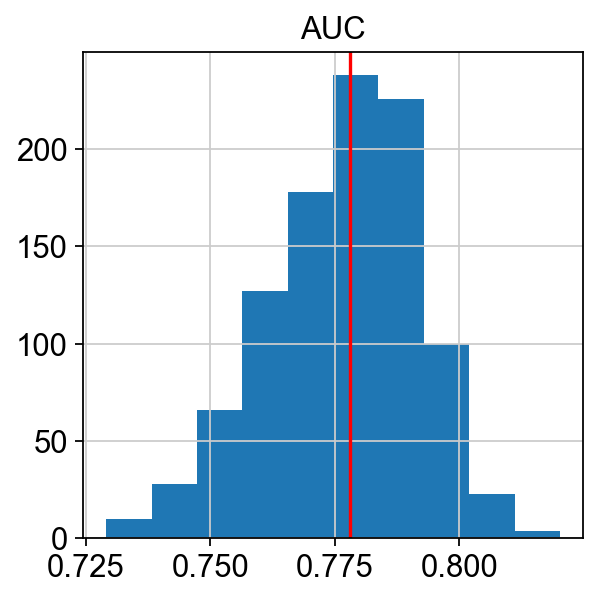



Median Accuracy = 73%. 
95.0 confidence interval: 65.5% and 76.4%.



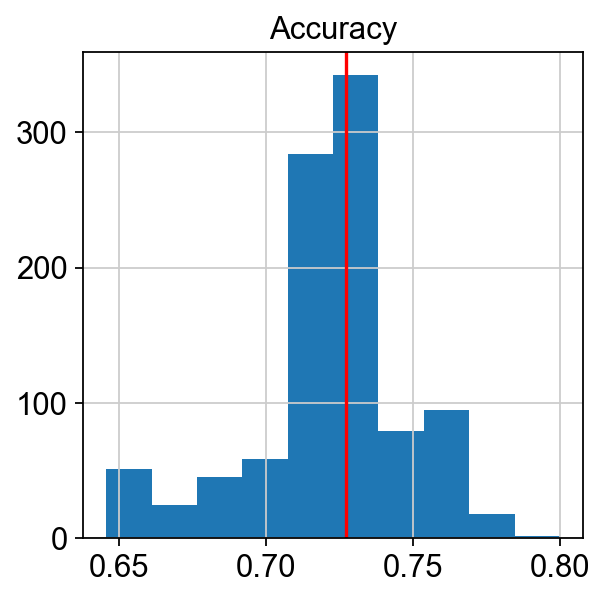



### Random Forest ###############################################################


Median AUC = 87%. 
95.0 confidence interval: 77.7% and 95.5%.



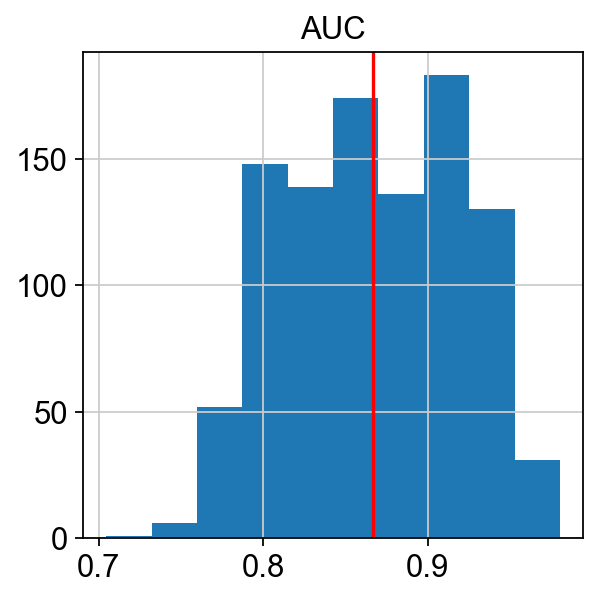



Median Accuracy = 81%. 
95.0 confidence interval: 69.1% and 90.0%.



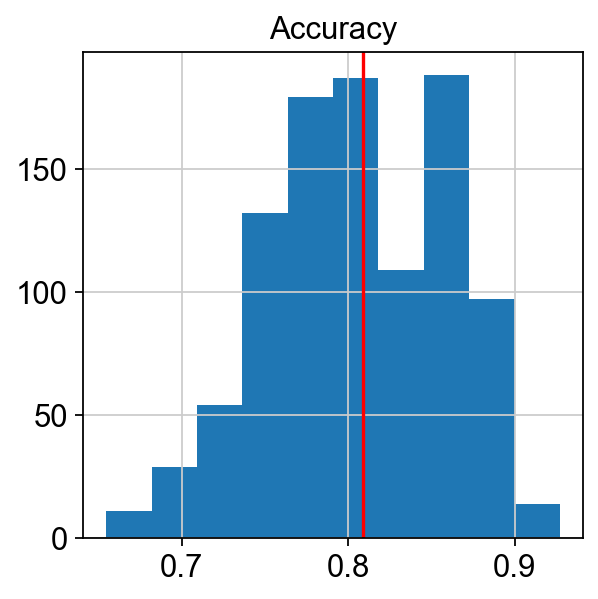

,AUC_lr_Full_Hierarchy,accuracy_lr_Full_Hierarchy,AUC_rf_Full_Hierarchy,accuracy_rf_Full_Hierarchy
0,0.775476,0.709091,0.850833,0.827273
1,0.783810,0.754545,0.863214,0.790909
2,0.756071,0.718182,0.887619,0.809091
3,0.792024,0.718182,0.868571,0.809091
4,0.776071,0.709091,0.938929,0.881818
...,...,...,...,...
995,0.793214,0.736364,0.942857,0.890909
996,0.759643,0.727273,0.827857,0.818182
997,0.749167,0.700000,0.866429,0.827273
998,0.762262,0.745455,0.896190,0.836364


In [86]:
# Try on LSC Prediction: Full Hierarchy 
performance_Engraftment_fullHierarchy = compare_repeated_nested_kfold_cv(y = y, x = x_celltype, feature_name = 'Full_Hierarchy', 
                                                                         n_iter = n_iterations, k_outer = 5, k_inner = 5, lr = True, rf = True)
performance_Engraftment_fullHierarchy

#### Classification with LSPC only



### LOGISTIC REGRESSION ###############################################################


Median AUC = 77%. 
95.0 confidence interval: 75.0% and 79.2%.



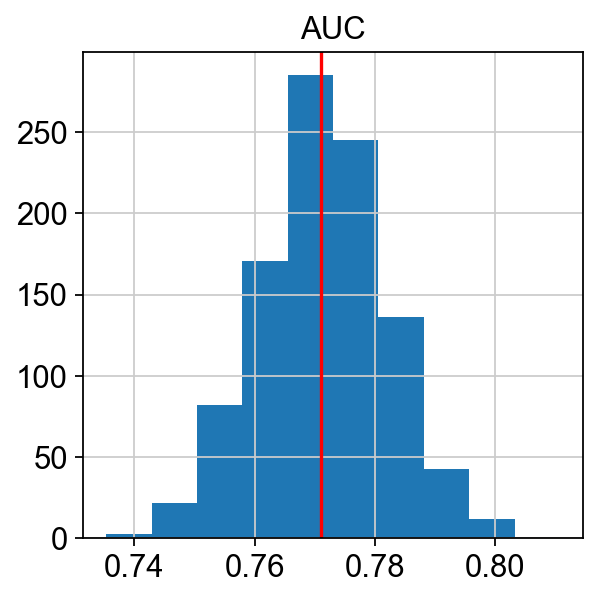



Median Accuracy = 72%. 
95.0 confidence interval: 70.0% and 73.6%.



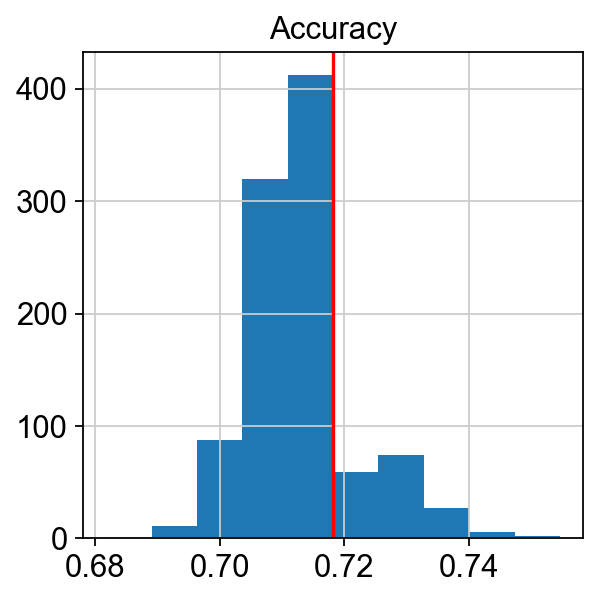



### Random Forest ###############################################################


Median AUC = 86%. 
95.0 confidence interval: 78.5% and 93.7%.



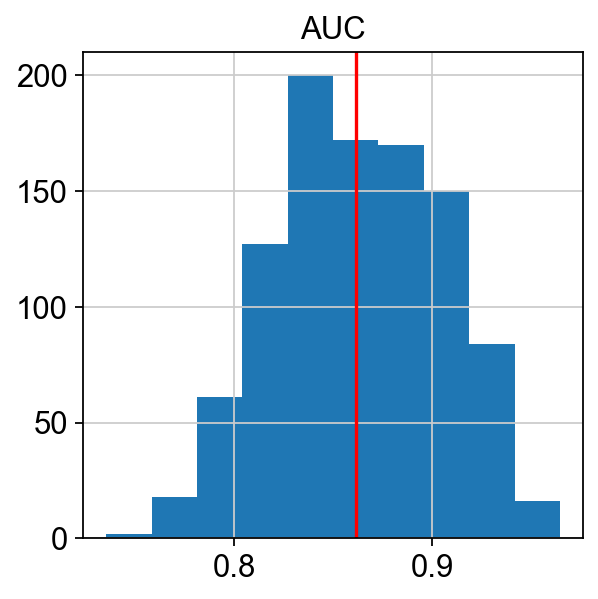



Median Accuracy = 79%. 
95.0 confidence interval: 68.2% and 88.2%.



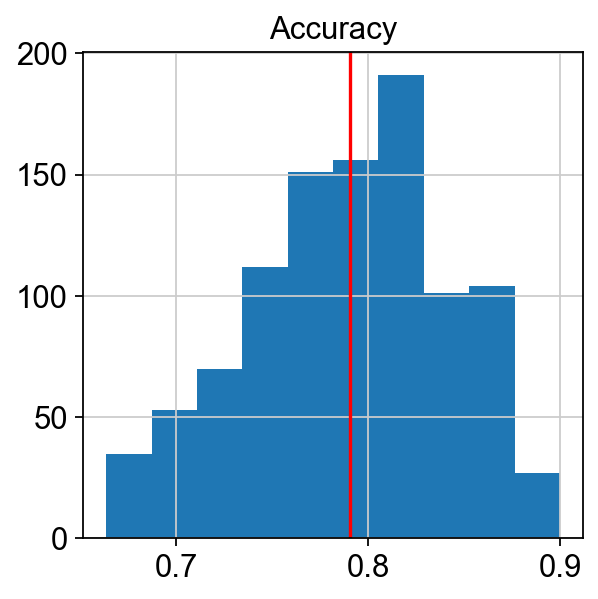

,AUC_lr_LSPC_only,accuracy_lr_LSPC_only,AUC_rf_LSPC_only,accuracy_rf_LSPC_only
0,0.761429,0.718182,0.849702,0.754545
1,0.763810,0.718182,0.851667,0.781818
2,0.759524,0.727273,0.767202,0.690909
3,0.772976,0.709091,0.935476,0.854545
4,0.766190,0.709091,0.813929,0.718182
...,...,...,...,...
995,0.764286,0.727273,0.906131,0.854545
996,0.773214,0.709091,0.881250,0.845455
997,0.763929,0.718182,0.885476,0.818182
998,0.773095,0.718182,0.880714,0.845455


In [87]:
performance_Engraftment_LSPC_only = compare_repeated_nested_kfold_cv(y = y, x = x_frac4levels[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle']], feature_name = 'LSPC_only', 
                                                                         n_iter = n_iterations, k_outer = 5, k_inner = 5, lr = True, rf = True)
performance_Engraftment_LSPC_only

#### Classification with Quiescent LSPC only



### LOGISTIC REGRESSION ###############################################################


Median AUC = 76%. 
95.0 confidence interval: 74.1% and 77.9%.



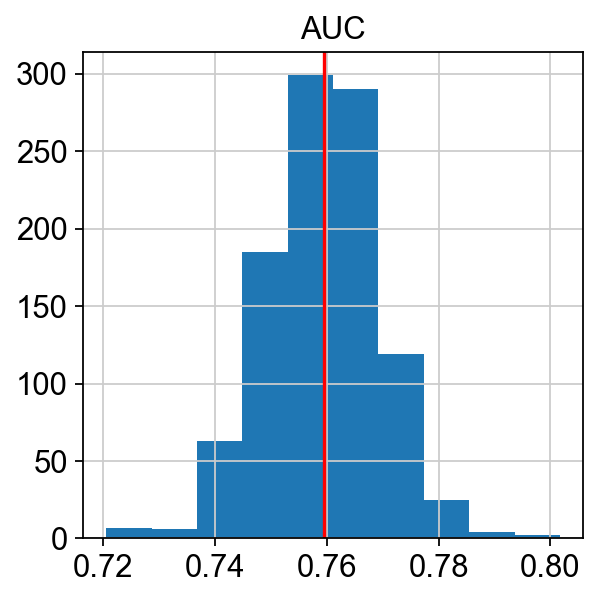



Median Accuracy = 69%. 
95.0 confidence interval: 68.2% and 72.7%.



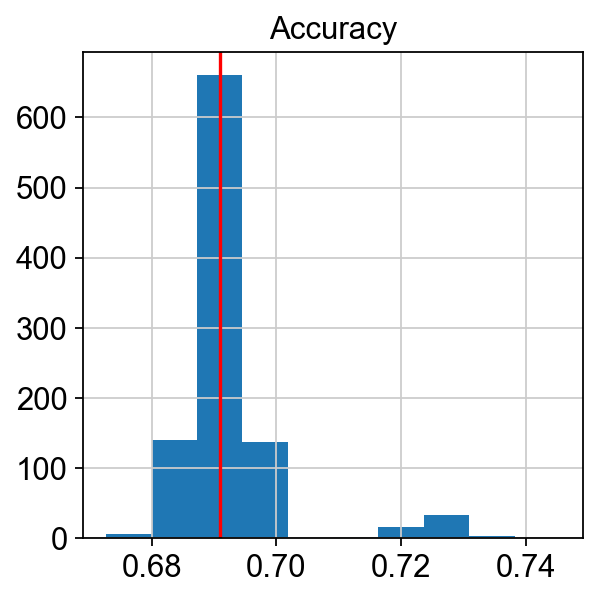



### Random Forest ###############################################################


Median AUC = 77%. 
95.0 confidence interval: 74.2% and 86.7%.



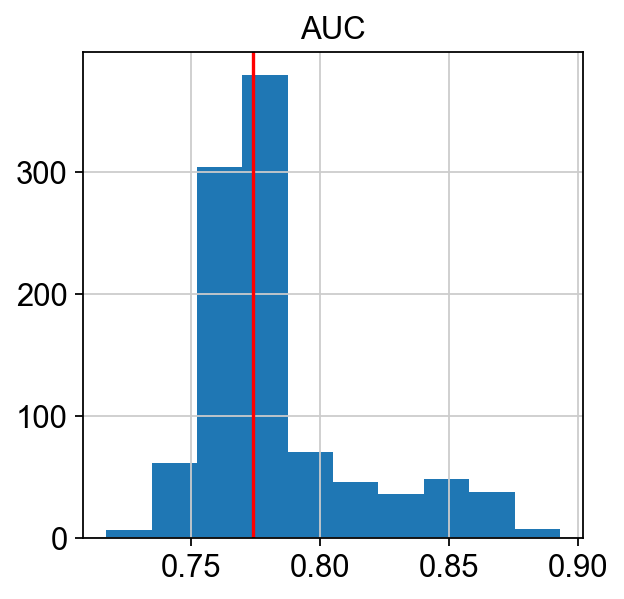



Median Accuracy = 74%. 
95.0 confidence interval: 71.8% and 79.1%.



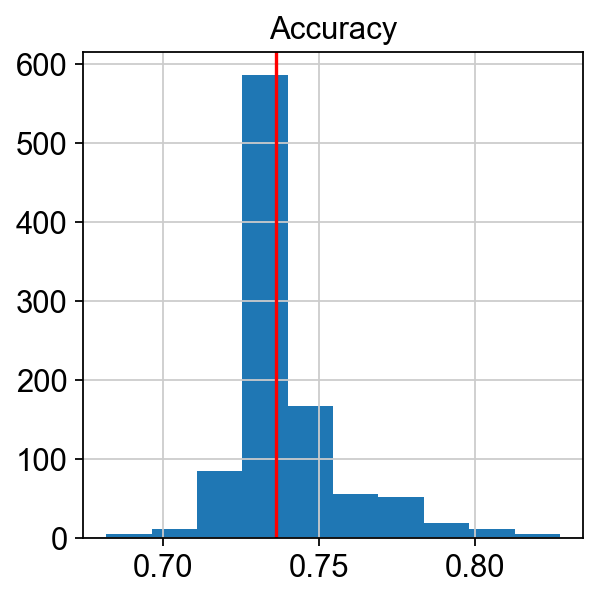

,AUC_lr_Quiescent_LSPC_only,accuracy_lr_Quiescent_LSPC_only,AUC_rf_Quiescent_LSPC_only,accuracy_rf_Quiescent_LSPC_only
0,0.762500,0.690909,0.768036,0.718182
1,0.742500,0.690909,0.758929,0.736364
2,0.754940,0.690909,0.763631,0.736364
3,0.774643,0.690909,0.867798,0.763636
4,0.756548,0.690909,0.763988,0.718182
...,...,...,...,...
995,0.755238,0.690909,0.764286,0.727273
996,0.765119,0.681818,0.769464,0.736364
997,0.754881,0.690909,0.771905,0.736364
998,0.756310,0.690909,0.770714,0.718182


In [88]:
performance_Engraftment_qLSPC_only = compare_repeated_nested_kfold_cv(y = y, x = x_frac4levels[['LSPC-Quiescent']], feature_name = 'Quiescent_LSPC_only', 
                                                                         n_iter = n_iterations, k_outer = 5, k_inner = 5, lr = True, rf = True)
performance_Engraftment_qLSPC_only

#### CD34/CD38 Immunophenotype

In [89]:
def run_repeated_nested_kfold_cv_immunophenotype(y, x, name, n_iter = 1000, k_outer = 5, k_inner = 5, lr = True, svc = True, knn = True, rf = True):

    performance = pd.DataFrame(index=list(range(0,n_iter)))

    if lr == True:
        print("\n\n### LOGISTIC REGRESSION ###############################################################")
        model = 'lr'

        temp_scores = repeated_nested_kfold(x, y, n_iterations = n_iter, model = model, features = name, k_inner=5, k_outer=5)
        performance = performance.join(temp_scores)

    if rf == True:
        print("\n\n### Random Forest ###############################################################")
        model = 'rf'

        temp_scores = repeated_nested_kfold(x, y, n_iterations = n_iter, model = model, features = name, k_inner=5, k_outer=5)
        performance = performance.join(temp_scores)
        
    return(performance)



### LOGISTIC REGRESSION ###############################################################


Median AUC = 70%. 
95.0 confidence interval: 68.3% and 72.5%.



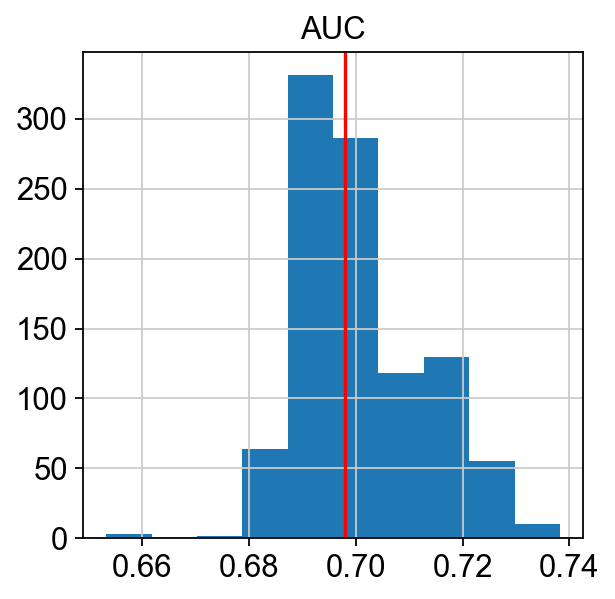



Median Accuracy = 65%. 
95.0 confidence interval: 65.5% and 67.3%.



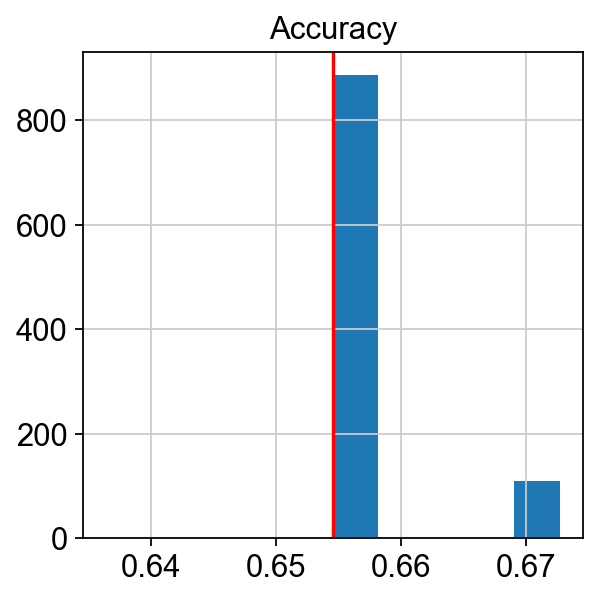



### Random Forest ###############################################################


Median AUC = 71%. 
95.0 confidence interval: 66.0% and 72.8%.



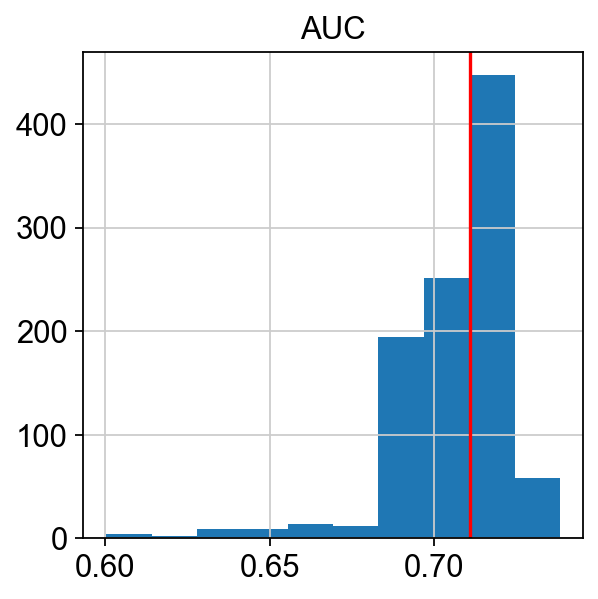



Median Accuracy = 65%. 
95.0 confidence interval: 65.5% and 67.3%.



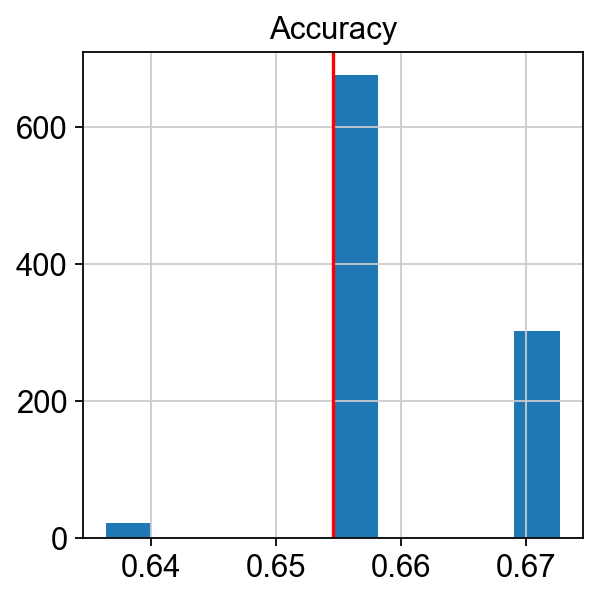

,AUC_lr_CD34CD38_Fraction,accuracy_lr_CD34CD38_Fraction,AUC_rf_CD34CD38_Fraction,accuracy_rf_CD34CD38_Fraction
0,0.698393,0.654545,0.698393,0.654545
1,0.697917,0.654545,0.723274,0.654545
2,0.698036,0.654545,0.706369,0.672727
3,0.691310,0.654545,0.691310,0.654545
4,0.691071,0.654545,0.691071,0.654545
...,...,...,...,...
995,0.700655,0.654545,0.706726,0.654545
996,0.697262,0.654545,0.709048,0.654545
997,0.698274,0.654545,0.718750,0.654545
998,0.699048,0.654545,0.699048,0.654545


In [90]:
performance_Engraftment_Fraction_only = run_repeated_nested_kfold_cv_immunophenotype(y = y, x = x_fraconly, name = 'CD34CD38_Fraction', 
                                                                                     n_iter = n_iterations, k_outer = 5, k_inner = 5, lr = True, rf = True)
performance_Engraftment_Fraction_only

In [118]:
LSC_benchmark_results = performance_Engraftment_Fraction_only.\
    join(performance_Engraftment_qLSPC_only).\
    join(performance_Engraftment_LSPC_only).\
    join(performance_Engraftment_fullHierarchy)

LSC_benchmark_results.index.name = 'iteration'
LSC_benchmark_results

,AUC_lr_CD34CD38_Fraction,accuracy_lr_CD34CD38_Fraction,AUC_rf_CD34CD38_Fraction,accuracy_rf_CD34CD38_Fraction,AUC_lr_Quiescent_LSPC_only,accuracy_lr_Quiescent_LSPC_only,AUC_rf_Quiescent_LSPC_only,accuracy_rf_Quiescent_LSPC_only,AUC_lr_LSPC_only,accuracy_lr_LSPC_only,AUC_rf_LSPC_only,accuracy_rf_LSPC_only,AUC_lr_Full_Hierarchy,accuracy_lr_Full_Hierarchy,AUC_rf_Full_Hierarchy,accuracy_rf_Full_Hierarchy
iteration,,,,,,,,,,,,,,,,
0,0.698393,0.654545,0.698393,0.654545,0.762500,0.690909,0.768036,0.718182,0.761429,0.718182,0.849702,0.754545,0.775476,0.709091,0.850833,0.827273
1,0.697917,0.654545,0.723274,0.654545,0.742500,0.690909,0.758929,0.736364,0.763810,0.718182,0.851667,0.781818,0.783810,0.754545,0.863214,0.790909
2,0.698036,0.654545,0.706369,0.672727,0.754940,0.690909,0.763631,0.736364,0.759524,0.727273,0.767202,0.690909,0.756071,0.718182,0.887619,0.809091
3,0.691310,0.654545,0.691310,0.654545,0.774643,0.690909,0.867798,0.763636,0.772976,0.709091,0.935476,0.854545,0.792024,0.718182,0.868571,0.809091
4,0.691071,0.654545,0.691071,0.654545,0.756548,0.690909,0.763988,0.718182,0.766190,0.709091,0.813929,0.718182,0.776071,0.709091,0.938929,0.881818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.700655,0.654545,0.706726,0.654545,0.755238,0.690909,0.764286,0.727273,0.764286,0.727273,0.906131,0.854545,0.793214,0.736364,0.942857,0.890909
996,0.697262,0.654545,0.709048,0.654545,0.765119,0.681818,0.769464,0.736364,0.773214,0.709091,0.881250,0.845455,0.759643,0.727273,0.827857,0.818182
997,0.698274,0.654545,0.718750,0.654545,0.754881,0.690909,0.771905,0.736364,0.763929,0.718182,0.885476,0.818182,0.749167,0.700000,0.866429,0.827273


In [109]:
performance_Engraftment_Fraction_only.to_csv("performance_Engraftment_Benchmarking.csv", index_label='iteration')

**Plot Benchmarking Results**

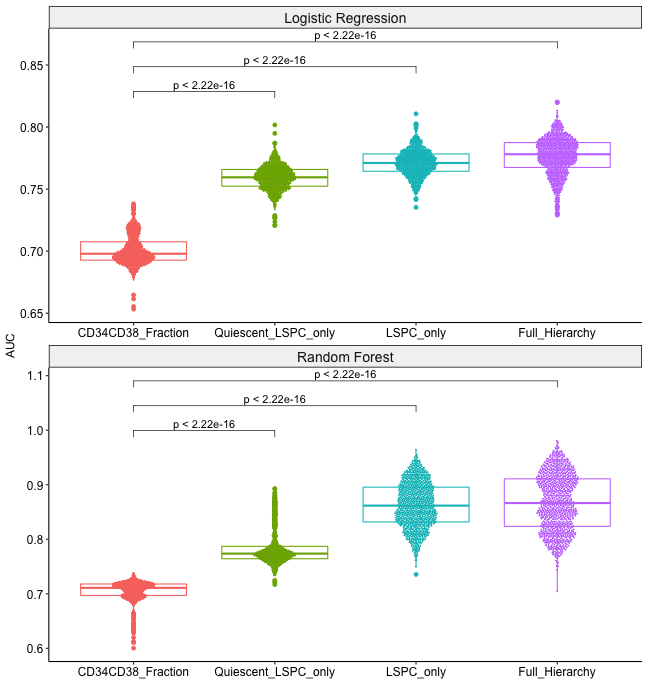

In [164]:
%%R -i LSC_benchmark_results -h 9.5 -w 9 --units in
benchmark_summarised <- LSC_benchmark_results %>% 
    rownames_to_column('Iteration') %>% 
    select('Iteration', contains('AUC')) %>% 
    pivot_longer(-Iteration, names_to = 'Features', values_to = 'AUC') %>% 
    mutate(Model = Features %>% str_replace('AUC_','') %>% str_replace('_.*',''), 
           Features = Features %>% str_replace(paste0('AUC_',Model,'_'),'')) %>% 
    select(Iteration, Features, Model, AUC) %>% 
    mutate(Features = Features %>% factor(levels = c('CD34CD38_Fraction', 'Quiescent_LSPC_only', 'LSPC_only', 'Full_Hierarchy')))
    
benchmark_summarised %>% 
    mutate(Model = ifelse(Model == 'lr', 'Logistic Regression', 'Random Forest')) %>% 
    ggplot(aes(x = Features, y = AUC, color = Features)) + 
    geom_boxplot() + ggbeeswarm::geom_quasirandom(width=0.15, size=0.005) + 
    facet_wrap(.~Model, ncol=1, scales='free') + 
    theme_pubr(legend = 'none') + theme(strip.text.x = element_text(size=14), axis.text.x = element_text(size=12), axis.title.x = element_blank()) + 
    stat_compare_means(comparisons = list(c('CD34CD38_Fraction', 'Quiescent_LSPC_only'), c('CD34CD38_Fraction', 'LSPC_only'), 
                                          c('CD34CD38_Fraction', 'Full_Hierarchy')))

AUC of Logistic Regression and Random Forest models from CD34/CD38 Immunophenotype is approximately 0.70 across the 1000 iterations. 

In contrast, using cell type abundance significantly improves model performance across all iterations in both models. 

For example: Full hierarchy deconvolution enables AUCs of 0.78 for logistic regression and 0.87 for random forest. 

Even qLSPC as a single variable outperforms immunophenotype in predicting LSC activity

## Association with Bulk LSC activity

A subset of samples from leucegene are annotated for bulk LSC frequency from Pabst et al. Does LSPC abundance correlate with bulk LSC frequency? 

In [18]:
import sys 
lab_path="/Users/andyzeng/Drive/Laptop/Dick_Lab/"
sys.path.append(lab_path+"AMLhierarchies/")

import Hierarchy_Tools as tk

... storing 'Sex' as categorical
... storing 'Status at sampling' as categorical
... storing 'Tissue' as categorical
... storing 'WHO 2008' as categorical
... storing 'FAB' as categorical
... storing 'Karyotype' as categorical
... storing 'Normal Karyotype' as categorical
... storing 'Status at last follow-up' as categorical
... storing 'Cytogenetic risk' as categorical
... storing 'EVI1_F' as categorical
... storing 'MLL_F' as categorical
... storing 'NUP98-NSD1' as categorical
... storing 'CBF' as categorical
... storing 'APL' as categorical
... storing 'Complex' as categorical
... storing 'Cohesin' as categorical
... storing 'Glucocorticoid_Response' as categorical
... storing 'Mubritinib_Response' as categorical
... storing 'LSC category' as categorical
... storing 'CR1' as categorical
... storing 'Allogeneic HSCT' as categorical
... storing 'Relapse' as categorical
... storing 'Deceased' as categorical


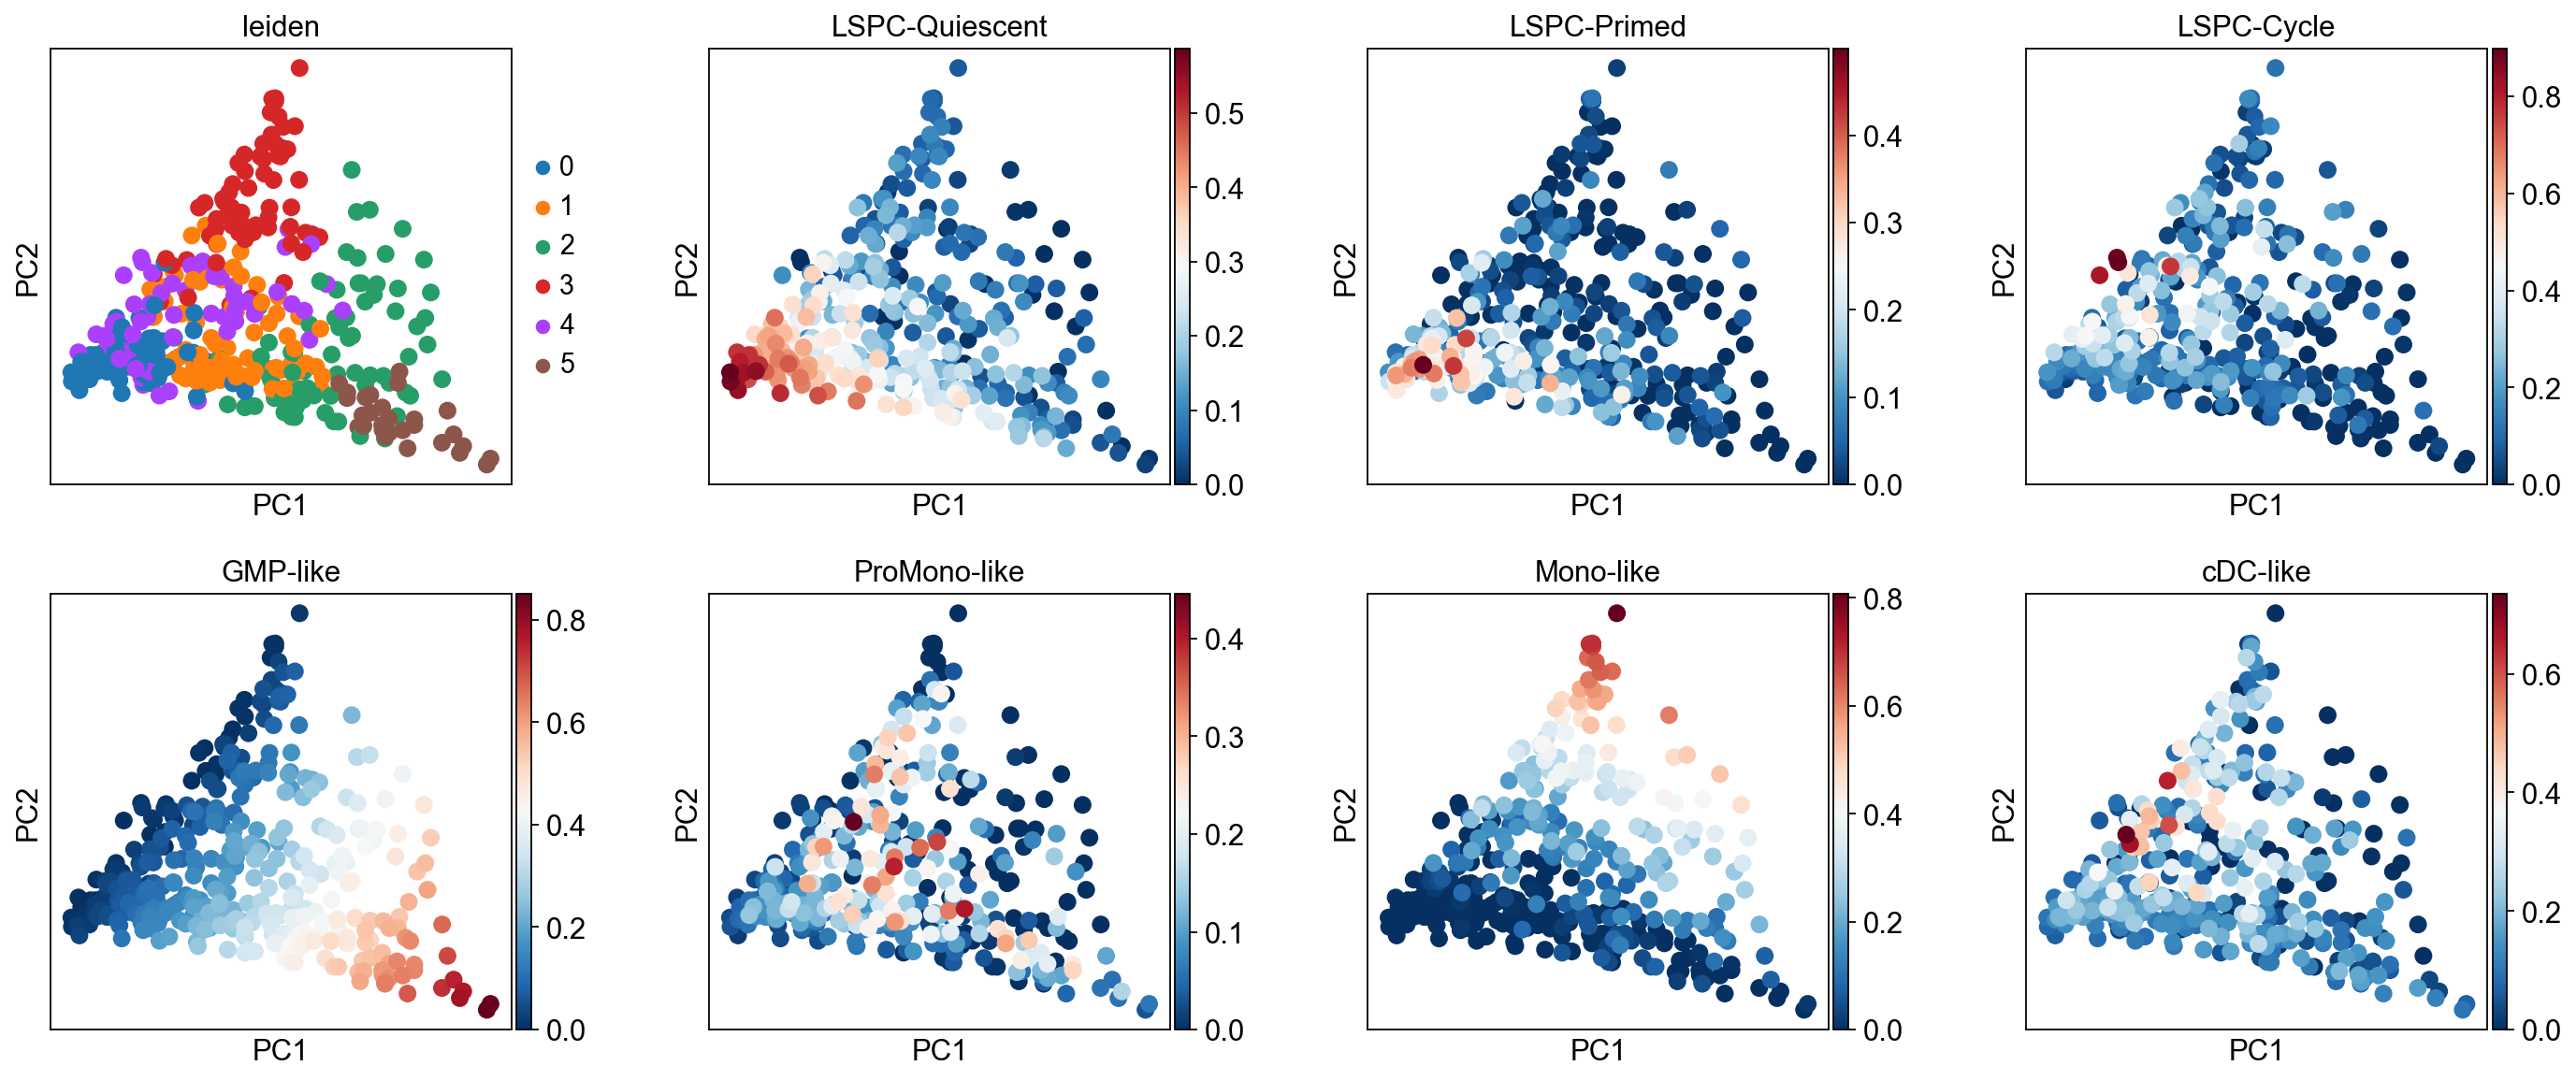

AnnData object with n_obs × n_vars = 410 × 7
    obs: 'Age', 'Sex', 'Status at sampling', 'Tissue', 'Blast%', 'CD34%', 'WBC', 'WHO 2008', 'FAB', 'Karyotype', 'Normal Karyotype', 'OS (days)', 'Status at last follow-up', 'Cytogenetic risk', 'ASXL1', 'ASXL2', 'CALR', 'CBL', 'CEBPA', 'CSF3R', 'DNMT3A', 'ETV6', 'FLT3', 'FLT3-ITD', 'GATA2', 'IDH1', 'IDH2', 'JAK2', 'KIT', 'KMT2A', 'KMT2C', 'KMT2D', 'KRAS', 'MYC', 'NF1', 'NPM1', 'NRAS', 'PTPN11', 'RAD21', 'RUNX1', 'SMC1A', 'SMC3', 'SMC5', 'SPI1', 'SRSF2', 'STAG2', 'TET2', 'TP53', 'U2AF1', 'WT1', 'ZBTB7A', 'HMGA2_TPM', 'EVI1_F', 'MLL_F', 'NUP98-NSD1', 'CBF', 'APL', 'Complex', 'Cohesin', 'Glucocorticoid_Response', 'Mubritinib_GI50', 'Mubritinib_Response', 'LSCF_absolute', 'LSC category', 'UPN', 'CR1', 'Allogeneic HSCT', 'Relapse', 'Deceased', 'Survival (days)', 'HMGA2 (RT-qPCR)', 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 

In [21]:
leuc = tk.load_Leucegene('Data/Fig2_Cohort_Deconvolution/CIBERSORTx_Results_Leucegene.csv')
leuc = tk.process_fractions(leuc)
leuc

In [22]:
leuc.obs['logLSC_Freq'] = np.log(leuc.obs['LSCF_absolute'])

In [24]:
leuc_todf = leuc.obs[['LSC category']].join(leuc.to_df())

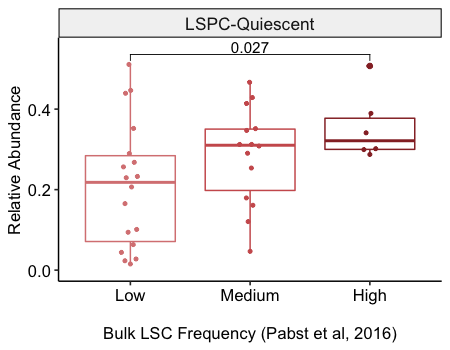

In [25]:
%%R -i leuc_todf -w 4.5 -h 3.5 --units in -r 100

hierarchy_colors = c('#d98383', '#cd5c5c', '#962e2e')


leuc_todf <- leuc_todf %>% 
    gather(-`LSC category`, key = "CellType", value = "Score") %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent')))#, 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
    
leuc_todf %>% 
    mutate(`LSC category` = ifelse(`LSC category` == 'LSChigh', 'High',
                                   ifelse(`LSC category` == 'LSCmed', 'Medium',
                                          ifelse(`LSC category` == 'LSClow', 'Low', 'NA'))) %>% 
          factor(levels = c('Low','Medium','High'))) %>%
    filter(`LSC category` != 'NA', CellType != 'NA') %>%
    ggplot(aes(x = `LSC category`, y = Score, color = `LSC category`)) + 
    geom_boxplot() + ggbeeswarm::geom_quasirandom(width=0.1, size=1) + 
    facet_wrap(.~CellType, ncol=4, scales='free') + 
    theme_pubr() + 
    theme(strip.text.x = element_text(size=12.5)) +
    stat_compare_means(label = "p.format", method='wilcox.test',
                       comparisons = list(c('Low', 'High'))) + 
    scale_color_manual(values = hierarchy_colors) +
    theme(legend.position='None') + ylim(0, 0.55) + 
    xlab('\nBulk LSC Frequency (Pabst et al, 2016)') + ylab('Relative Abundance')